# Traffic Sign Classifier
## Deep Learning
## Project: Build a Traffic Sign Recognition Classifier

The goals / steps of this project are the following:
* Load the data set (see below for links to the project data set)
* Explore, summarize and visualize the data set
* Design, train and test a model architecture
* Use the model to make predictions on new images
* Analyze the softmax probabilities of the new images
* Summarize the results with a written report


## Import the required libraries

In [1]:
import tensorflow as tf
import tensorflow.contrib.slim as slim 
from tensorflow.contrib.layers import flatten
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import numpy as np
import cv2
import math
import os
import time
import pickle
%matplotlib inline

### Parameter Settings 

In [2]:
# Constants
IMG_SIZE = 32  # square image of size IMG_SIZE x IMG_SIZE
GRAYSCALE = False  # convert image to grayscale?
NUM_CHANNELS = 1 if GRAYSCALE else 3
NUM_CLASSES = 43

In [3]:
# Model parameters
learningrate = 5e-3  # learning rate
KEEP_PROB = 0.5  # dropout keep probability

In [4]:
# Training process
RESTORE = False  # restore previous model, don't train?
RESUME = False  # resume training from previously trained model?
NUM_EPOCH = 100
BATCH_SIZE = 128  # batch size for training (relatively small)
BATCH_SIZE_INF = 2048  # batch size for running inference, e.g. calculating accuracy
SAVE_MODEL = True  # save trained model to disk?
MODEL_SAVE_PATH = 'model.ckpt'  # where to save trained model

# Step 0: Load The Data

Load the Traffic Sign data

In [5]:
training_file = 'train.p'
validation_file = 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


# Step 1: Dataset Summary & Exploration

## Dataset Summary

In [6]:
### To start off let's do a basic data summary.

# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples
n_test = X_test.shape[0]

# What's the shape of an image?
image_shape = X_train[0].shape

# How many classes are in the dataset
n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Display 20 Sign Names head and tail 

In [7]:
sign_names = pd.DataFrame(pd.read_csv('signnames.csv'))

In [8]:
sign_names.head(20)

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


In [9]:
sign_names.tail(20)

,ClassId,SignName
23,23,Slippery road
24,24,Road narrows on the right
25,25,Road work
26,26,Traffic signals
27,27,Pedestrians
28,28,Children crossing
29,29,Bicycles crossing
30,30,Beware of ice/snow
31,31,Wild animals crossing
32,32,End of all speed and passing limits


## Exploratory Visualization
Display 10 random traffic signs

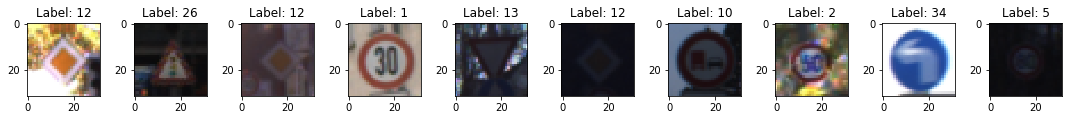

In [10]:
num_images = 10
indices = np.random.choice(list(range(n_train)), size=num_images, replace=False)

# Obtain the images and labels
images = X_train[indices]
labels = y_train[indices]

# Display the images
plt.rcParams["figure.figsize"] = [15, 5]

for i, image in enumerate(images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(image)
    plt.title('Label: %d' % labels[i])
    
plt.tight_layout()
plt.show()


### Distribution of Classes in the Training, Validation and Test set

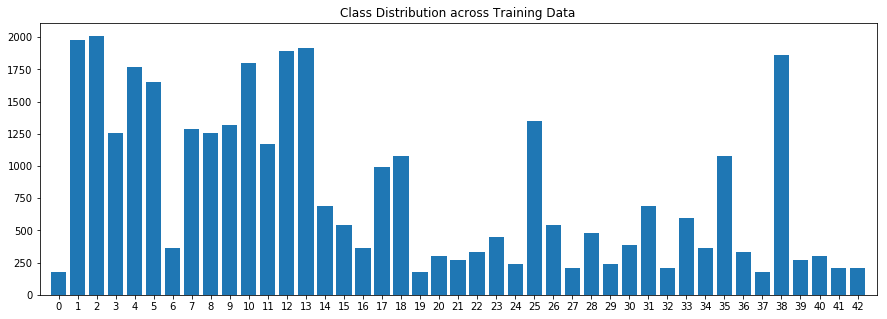

In [11]:
# Count frequency of each label
labels, counts = np.unique(y_train, return_counts=True)

# Plot the histogram
plt.rcParams["figure.figsize"] = [15, 5]
axes = plt.gca()
axes.set_xlim([-1,43])

plt.bar(labels, counts, tick_label=labels, width=0.8, align='center')
plt.title('Class Distribution across Training Data')
plt.show()

The training data's class distribution is highly skewed.

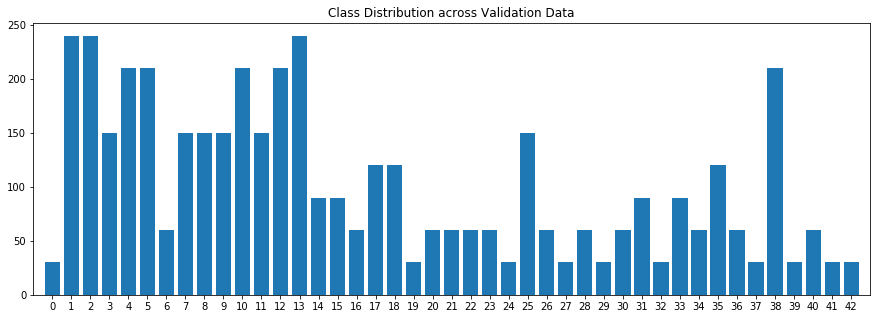

In [12]:
# Count frequency of each label
labels, counts = np.unique(y_valid, return_counts=True)

# Plot the histogram
plt.rcParams["figure.figsize"] = [15, 5]
axes = plt.gca()
axes.set_xlim([-1,43])

plt.bar(labels, counts, tick_label=labels, width=0.8, align='center')
plt.title('Class Distribution across Validation Data')
plt.show()

The validation  data is also skewed, in the same way the training data is skewed. The only difference is the individual counts for each class are less.

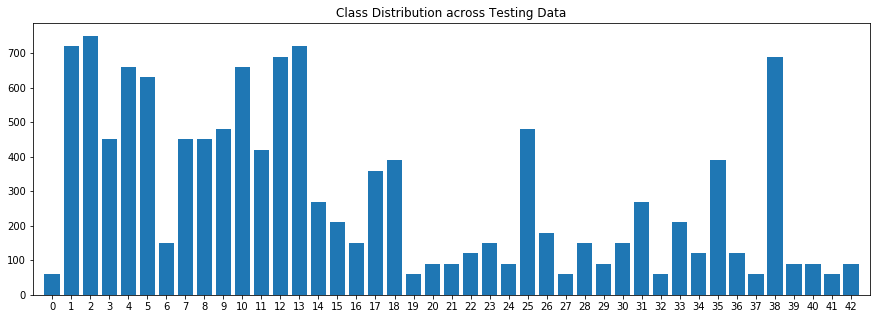

In [13]:
# Count frequency of each label
labels, counts = np.unique(y_test, return_counts=True)

# Plot the histogram
plt.rcParams["figure.figsize"] = [15, 5]
axes = plt.gca()
axes.set_xlim([-1,43])

plt.bar(labels, counts, tick_label=labels, width=0.8, align='center')
plt.title('Class Distribution across Testing Data')
plt.show()

The test data is also skewed, in the same way the training data is skewed. The only difference is the individual counts for each class are less.

# Step 2: Design and Test of Model Architecture

### Pre-process the Data Set (normalization, grayscale, etc.)
 
I performed the following data preprocessing steps:

* Initial test of the model performance with current dataset without twicking any parameters

 * Trying to get the model to perform with an accuracy rate over 93% is quite tricky because they are so many paremeters that can be tuned and twicked. There are multiple approaches my first step for the machine learning pipeline was to run the model first and then pre-process the data.
 
 
* Image Augmentation details are explained the "How I did Data Augmentation" section


* Standardize the pixel values: `new_value = (old_value - 128) / 128`
  * This has the effect of zero-centering the data, and making the data fall within the range -1 to 1
  * Standardizing the pixel values helps gradient descent converge faster
  * Dividing the pixel values by 128 is not strictly necessary for this project, because all original pixel values are on the same scale, from 0 to 255. However, this division step is computationally cheap, and it's good practice in the long term to standardize the image preprocessing requirements, over many different projects with potentially different image representations. Over the course of many projects in the future, abiding by this practice can help reduce confusion and potential frustration.
  
* Convert the integer class labels into one-hot encoded labels
  * This is important because different traffic signs do not have integer-like relationships with one another. For example, if a stop sign is labeled 0, a speed limit sign labeled 1, and a yield sign labeled 2, an integer label would imply a stop sign is more similar to a speed limit sign than a yield sign. A neural network classifier would mathematically assume this relationship as well. Practically, there is no such relationship. By converting all labels into one-hot encoded labels, we avoid this incorrect underlying assumption.
  
* Randomly shuffle the data 
 * It is extremely important to shuffle the training data, so that we do not obtain entire minibatches of    highly correlated examples
 * If the data is given in some meaningful order, this can bias the gradient and lead to poor convergence. 

In [14]:
def preprocess_data_shuffle(X, y):
    """
    Preprocess image data, and convert labels into one-hot
    and shuffle the data
    Arguments:
        * X: Image data
        * y: Labels

    Returns:
        * Preprocessed X_shuffled, one-hot version of y_shuffled
    """
    # Convert from RGB to grayscale if applicable
    if GRAYSCALE:
        X = rgb_to_gray(X)

    # Make all image array values fall within the range -1 to 1
    # Note all values in original images are between 0 and 255, as uint8
    X = X.astype('float32')
    X = (X - 128.) / 128.

    # Convert the labels from numerical labels to one-hot encoded labels
    y_onehot = np.zeros((y.shape[0], NUM_CLASSES))
    for i, onehot_label in enumerate(y_onehot):
        onehot_label[y[i]] = 1.
    y = y_onehot
    #Shuffle the data
    X_shuffled, y_shuffled = shuffle(X, y)
    return X_shuffled, y_shuffled

In [15]:
def preprocess_data(X, y):
    """
    Preprocess image data, and convert labels into one-hot

    Arguments:
        * X: Image data
        * y: Labels

    Returns:
        * Preprocessed X, one-hot version of y
    """
    # Convert from RGB to grayscale if applicable
    if GRAYSCALE:
        X = rgb_to_gray(X)

    # Make all image array values fall within the range -1 to 1
    # Note all values in original images are between 0 and 255, as uint8
    X = X.astype('float32')
    X = (X - 128.) / 128.

    # Convert the labels from numerical labels to one-hot encoded labels
    y_onehot = np.zeros((y.shape[0], NUM_CLASSES))
    for i, onehot_label in enumerate(y_onehot):
        onehot_label[y[i]] = 1.
    y = y_onehot
    
    return X, y

In [16]:
def next_batch(X, y, batch_size, augment_data):
    """
    Generator to generate data and labels
    Each batch yielded is unique, until all data is exhausted
    If all data is exhausted, the next call to this generator will throw a StopIteration

    Arguments:
        * X: image data, a tensor of shape (dataset_size, 32, 32, 3)
        * y: labels, a tensor of shape (dataset_size,)  <-- i.e. a list
        * batch_size: Size of the batch to yield
        * augment_data: Boolean value, whether to augment the data (i.e. perform image transform)

    Yields:
        A tuple of (images, labels), where:
            * images is a tensor of shape (batch_size, 32, 32, 3)
            * labels is a tensor of shape (batch_size,)
    """
    
    # We know X and y are randomized from the train/validation split already,
    # so just sequentially yield the batches
    start_idx = 0
    while start_idx < X.shape[0]:
        images = X[start_idx : start_idx + batch_size]
        labels = y[start_idx : start_idx + batch_size]

        yield (np.array(images), np.array(labels))

        start_idx += batch_size

In [17]:
def calculate_accuracy(data_gen, data_size, batch_size, accuracy, x, y, keep_prob, sess):
    """
    Helper function to calculate accuracy on a particular dataset

    Arguments:
        * data_gen: Generator to generate batches of data
        * data_size: Total size of the data set, must be consistent with generator
        * batch_size: Batch size, must be consistent with generator
        * accuracy, x, y, keep_prob: Tensor objects in the neural network
        * sess: TensorFlow session object containing the neural network graph

    Returns:
        * Float representing accuracy on the data set
    """
    num_batches = math.ceil(data_size / batch_size)
    last_batch_size = data_size % batch_size

    accs = []  # accuracy for each batch

    for _ in range(num_batches):
        images, labels = next(data_gen)

        # Perform forward pass and calculate accuracy
        # Note we set keep_prob to 1.0, since we are performing inference
        acc = sess.run(accuracy, feed_dict={x: images, y: labels, keep_prob: 1.})
        accs.append(acc)

    # Calculate average accuracy of all full batches (the last batch is the only partial batch)
    acc_full = np.mean(accs[:-1])

    # Calculate weighted average of accuracy accross batches
    acc = (acc_full * (data_size - last_batch_size) + accs[-1] * last_batch_size) / data_size

    return acc

### How I did Data Augmentation

1. Defined few image transformation methods (rotation, shift, shear, blurr , change gamma).
2. Defined a method `random_transform()` to randomly apply multiple transformation on one image.

Since the traffic sign samples is not distrubted equally, this could affect the CNN's performance. The network would be biased toward classes with more samples. **Data Augmentation** generates additional data on each traffic sign. For example, if the average sample for each classes is 1000 images. Any class has less than 300 images need to generate more data. 

Data Augmentation includes but not limited to *blurring, rotating, shearing, translating, changing brighness* on original images.
For image transformation, I found this documentation from [OpenCV](http://docs.opencv.org/trunk/da/d6e/tutorial_py_geometric_transformations.html) is helpful: 

In [18]:
def translate(img):
    "Shift orginal image around within image size"
    x = img.shape[0]
    y = img.shape[1]
    x_shift = np.random.uniform(-0.3 * x, 0.3 * x)
    y_shift = np.random.uniform(-0.3 * y, 0.3 * y)
    shift_matrix = np.float32([[1, 0, x_shift], [0, 1, y_shift]])
    shift_img = cv2.warpAffine(img, shift_matrix, (x, y))
    return shift_img

def rotate(img):
    " Rotate original image at random rotation angle from -90 degree to +90 degree"
    row, col, channel = img.shape
    angle = np.random.uniform(-90, 90)
    rotation_point = (row / 2, col / 2)
    rotation_matrix = cv2.getRotationMatrix2D(rotation_point, angle, 1)
    rotated_img = cv2.warpAffine(img, rotation_matrix, (col, row))
    return rotated_img

def shear(img):
    " Affirm Transformation orignal image"
    x, y, channel = img.shape
    shear = np.random.randint(5,15)
    pts1 = np.array([[5, 5], [20, 5], [5, 20]]).astype('float32')
    pt1 = 5 + shear * np.random.uniform() - shear / 2
    pt2 = 20 + shear * np.random.uniform() - shear / 2
    pts2 = np.float32([[pt1, 5], [pt2, pt1], [5, pt2]])
    M = cv2.getAffineTransform(pts1, pts2)
    result = cv2.warpAffine(img, M, (y, x))
    return result

def blur(img):
    r_int = np.random.randint(0, 2)
    odd_size = 2 * r_int + 1
    return cv2.GaussianBlur(img, (odd_size, odd_size), 0)


def gamma(img):
    gamma = np.random.uniform(0.2, 1.5)
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    new_img = cv2.LUT(img, table)
    return new_img

def random_transform(img):
    # There are total of 6 transformation
    # I will create an boolean array of 6 elements [ 0 or 1]
    a = np.random.randint(0, 2, [1, 5]).astype('bool')[0]
    if a[0] == 1: img = translate(img)
    if a[1] == 1: img = rotate(img)
    if a[2] == 1: img = shear(img)
    if a[3] == 1: img = blur(img)
    if a[4] == 1: img = gamma(img)
        
    return img

## Generate and Augment Images
I generate 5 images per transformation on a random image of training set.

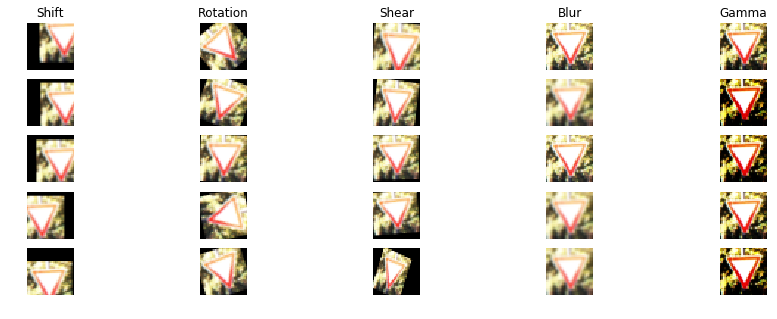

In [19]:
i = 22700
sample_1 = X_train[i]
translated_img = []
rotated_img = []
shear_img = []
blur_img = []
noise_img = []
gamma_img=[]
for i in range(5):
    translated_img.append(translate(sample_1)),rotated_img.append(rotate(sample_1))
    shear_img.append(shear(sample_1)), blur_img.append(blur(sample_1)), gamma_img.append(gamma(sample_1))
    
row, col = 5, 5
plt.figure(2)
plt.subplot(row, col,1), plt.title('Shift'), plt.subplot(row, col,2), plt.title('Rotation')
plt.subplot(row, col,3), plt.title('Shear'), plt.subplot(row, col,4), plt.title('Blur')
plt.subplot(row, col,5), plt.title('Gamma')

for i in range(5):
    pos = 5*i
    plt.subplot(row, col,pos+1), plt.imshow(translated_img[i]),  plt.axis('off')
    plt.subplot(row, col,pos+2), plt.imshow(rotated_img[i]), plt.axis('off') 
    plt.subplot(row, col,pos+3), plt.imshow(shear_img[i]), plt.axis('off')
    plt.subplot(row, col,pos+4), plt.imshow(blur_img[i]), plt.axis('off')  
    plt.subplot(row, col,pos+5), plt.imshow(gamma_img[i]), plt.axis('off')

### Test the multiple transformations on one image

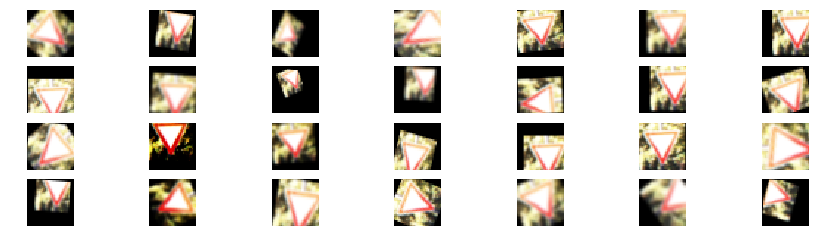

In [20]:
for j in range(5):
    pos=5*j
    for i in range(8):
        test = random_transform(sample_1)
        plt.subplot(5, 7, pos+i+1), plt.imshow(test), plt.axis('off')

### Generate New Dataset using Image Transformation.

We have a way to generate additional data now. However, each class in dataset should have different needed amount of additional data.

In [21]:
# Based on that average, we can estimate how many images a traffic sign need to have
total_traffic_signs = len(set(y_train))
# Calculate how many images in one traffic sign
ts, imgs_per_sign = np.unique(y_train, return_counts=True)
avg_per_sign = np.ceil(np.mean(imgs_per_sign)).astype('uint32')

separated_data = []
for traffic_sign in range(total_traffic_signs):
    images_in_this_sign = X_train[y_train == traffic_sign,...]
    separated_data.append(images_in_this_sign)

In [22]:
# For each dataset, I generate new images randomly based on current total images       
expanded_data = np.array(np.zeros((1, 32,32,3)))
expanded_labels = np.array([0])

for sign, sign_images in enumerate(separated_data):
    scale_factor = (4*(avg_per_sign/imgs_per_sign[sign])).astype('uint32')
    new_images = []
    # Generate new images  <---- Could apply list comprehension here
    for img in sign_images:
        for _ in range(scale_factor):
            new_images.append(random_transform(img))
    # Add old images and new images into 1 array    
    if len(new_images) > 0:
        sign_images = np.concatenate((sign_images, new_images),axis=0)
    new_labels = np.full(len(sign_images),sign, dtype ='uint8')
    # Insert new_images to current dataset
    expanded_data = np.concatenate((expanded_data,sign_images), axis = 0)
    expanded_labels = np.concatenate((expanded_labels, new_labels), axis=0)
    augmented_train = {'features': expanded_data, 'labels': expanded_labels}

In [23]:
augmented_X_train, augmented_y_train = augmented_train['features'], augmented_train['labels']

### Compare results Before and After Data Augmentation

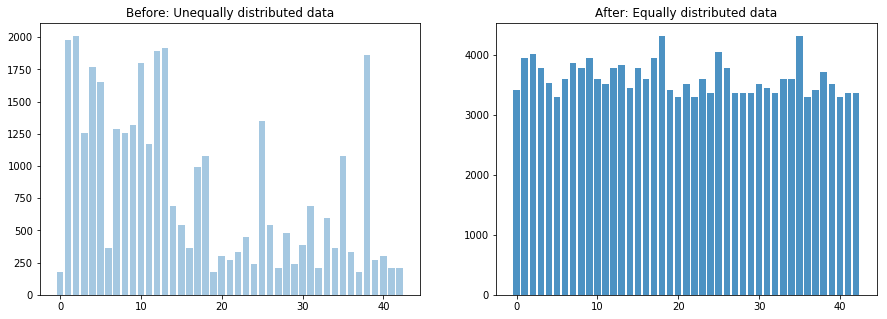

In [24]:
# Create a barchart of frequencies
item, count = np.unique(y_train, return_counts=True)
freq = np.array((item, count)).T
item2, count2 = np.unique(augmented_y_train, return_counts=True)
freq2 = np.array((item2, count2)).T

plt.figure(figsize=(15, 5))
before = plt.subplot(1,2, 1)
after = plt.subplot(1,2,2)
before.bar(item, count, alpha=0.4), after.bar(item2, count2, alpha=0.8)
before.set_title("Before: Unequally distributed data", size=12)
after.set_title("After: Equally distributed data", size=12)

### Do a Data Summary for the Augment Data

In [25]:
### To start off let's do a basic data summary.

# Number of training examples
n_train = augmented_X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples
n_test = X_test.shape[0]

# What's the shape of an image?
image_shape = augmented_X_train[0].shape

# How many classes are in the dataset
n_classes = np.unique(augmented_y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 155275
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [26]:
X_train = augmented_X_train
y_train = augmented_y_train 

### Pre-processing image data for model input
is quite important that the data is shuffled to remove the influence of drifts within the data.
I have managed to get quite a good validation accuracy without augmenting the data to create a much larger data set. 

In [27]:
X_train, y_train = preprocess_data_shuffle(X_train, y_train)
X_test, y_test = preprocess_data_shuffle(X_test, y_test)
X_valid, y_valid = preprocess_data_shuffle(X_valid, y_valid)

## Model Architecture
I have implemented the Traffic Sign Recognition with Multi-Scale Convolutional Network using [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). 
The model was implemented using TensorFlow-Slim. TF-Slim is a lightweight library for defining, training and evaluating complex models in TensorFlow. 
with the following differences:
* The overall dimensions of each layer are smaller, because our input image dimensions are smaller than that of the ImageNet challenge, and because we are trying to identify less classes
* I did not downsample in the first convolutional layer like AlexNet did, because our input image dimensions are so small
* I have one less convolution layer after the 2nd pooling layer

I also tried various convolutional neural network architectures:
- VGGNet
- GoogLeNet
- ResNet

It takes a significant amount of effort to twick the filter sizes, strides, padding to be able to get the model to perform well.

### My final model consists of the following layers:

In summary, my neural network architecture consists of the following 12 layers:

* Convolution with 3x3 kernel, stride of 1, depth of 16, same padding
* Max pooling with 3x3 kernel, stride of 1, same padding
* Convolution with 5x5 kernel, stride of 3, depth of 64, valid padding
* Max pooling with 3x3 kernel, stride of 1, valid padding
* Convolution with 3x3 kernel, stride of 1, depth of 128, same padding
* Convolution with 3x3 kernel, stride of 1, depth of 64, same padding
* Max pooling with 3x3 kernel, stride of 1, valid padding
* Fully Connected Layer with 1024 hidden units
* Dropout layer to prevent overfittiing
* Fully Connected Layer 2 with 1024 hidden units
* Dropout Layer to prevent overfittiing
* Fully-connected with 43 units, corresponding to the 43 target classes

![Model Architecture](CNNArchitecture.jpg)


I used dropout on the fully-connected layers to prevent overfitting.

Batch normalization was applied after the convolutional layers, to (a) make the model more robust to bad random weight initialization, (b) allow higher learning rates, and (c) help with regularization. More details about batch normalization are availabe at https://arxiv.org/abs/1502.03167 and http://cs231n.github.io/neural-networks-2/#batchnorm

### The Tensor Graph 
![Tensor Graph](graph_run.png)

In [28]:
def conv_neural_net():
    """
    Define Convolutional Neural Network Architecture
    Return the relevant tensor references
    """
    with tf.variable_scope('Convolutional_Neural_Network'):
        # Tensors representing input images and labels
        x = tf.placeholder('float', [None, IMG_SIZE, IMG_SIZE, NUM_CHANNELS])
        y = tf.placeholder('float', [None, NUM_CLASSES])

        # Placeholder for dropout keep probability
        keep_prob = tf.placeholder(tf.float32)

        # Use batch normalization for all convolution layers
        with slim.arg_scope([slim.conv2d], normalizer_fn=slim.batch_norm):
            # Given x shape is (32, 32, 3)
            # Conv and pool layers
            net = slim.conv2d(x, 16, [3, 3], scope='conv1')  # output shape: (32, 32, 16)
            net = slim.max_pool2d(net, [3, 3], 1, padding='SAME', scope='pool1')  # output shape: (32, 32, 16)
            net = slim.conv2d(net, 64, [5, 5], 3, padding='VALID', scope='conv2')  # output shape: (10, 10, 64)
            net = slim.max_pool2d(net, [3, 3], 1, scope='pool2')  # output shape: (8, 8, 64)
            net = slim.conv2d(net, 128, [3, 3], scope='conv3')  # output shape: (8, 8, 128)
            net = slim.conv2d(net, 64, [3, 3], scope='conv4')  # output shape: (8, 8, 64)
            net = slim.max_pool2d(net, [3, 3], 1, scope='pool3')  # output shape: (6, 6, 64)

            # Final fully-connected layers
            net = tf.contrib.layers.flatten(net)
            net = slim.fully_connected(net, 1024, scope='fc1')
            net = tf.nn.dropout(net, keep_prob)
            net = slim.fully_connected(net, 1024, scope='fc2')
            net = tf.nn.dropout(net, keep_prob)
            net = slim.fully_connected(net, NUM_CLASSES, scope='fc3')

        # Final output (logits)
        logits = net

        # Loss function and optimizer
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learningrate).minimize(loss)
        # Prediction (used during inference)
        predictions = tf.argmax(logits, 1)

        # Accuracy metric calculation
        correct_prediction = tf.equal(predictions, tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    # Return relevant tensor references
    return x, y, keep_prob, logits, optimizer, predictions, accuracy

### Train, Validate and Test the Model
**Describe how you trained your model:**

To train the model, I used standard Stochastic Gradient Descent (SGD). I experimented with other optimizers like ADAM, but the performance was not good. I twicked the number of epochs ranging from 50 to 100 until I got a model validation accuracy of 96.16%. The learning rate remained unchanged throughout. I also adjusted the drop rate to adjust for overfitting from a value of 0.5 to 0.75 which resulted in very poor performance. I also tried to automate the process by using grid search hyperparameter tuning techniques on the learning rate, dropout rate, epochs and number of fully connected layers. This proved to be quite compute intensive, grid search ran for days and I had to abandon the idea until I had more computational resources. So I resorted to a random hyperparameter search method.

When choosing a training batch size, I kept the following in mind:
* Batch size too small: Initial gradient updates will exhibit significant variance, causing slow convergence.
* Batch size too big: Either (a) my GPU will simply run out of memory, or (b) a single gradient update will take too long, to a point where it is not worth the extra variance reduction from going to a larger batch size (we are basically trying to "optimize" the gradient descent convergence speed).

Thus I chose a middle ground between the two extremes. I was not methodical in this process of batch size tuning, due to time constraints, and the resulting performance optimization derived from of tuning the batch size did not seem high.

The number of epochs was chosen such that it is large enough to see the training and validation accuracies saturating. This means the model cannot improve anymore, given more training time.

The hyperparameters were chosen based on a random hyperparameter combination search. The code to perform the search is available in `search_params.py`. In this process, I randomly chose 20 hyperparameter combinations, ran training on my model, and chose the hyperparameter combination that gave the highest test accuracy. ter combination was the best, since the test set should be "hidden" until the model has been finalized.

Looking at the plot of train vs. validation accuracy, we can see the validation accuracy is only slighly below the training accuracy throughout the training process, which is a good indication of model performance.

The model's accuracy on the official test set is 96.41%, which is a good score.

Below are my final settings and hyperparameters I used to train my model:
* Number of epochs: 100
* Batch size: 128
* Optimizer: Stochastic gradient descent (tf.train.GradientDescentOptimizer)
* Learning rate: 5e-3
* Dropout keep-probability: 0.5

In [29]:
def train_network():
    # Launch the graph
    with tf.Graph().as_default(), tf.Session() as sess:
        ########################################################
        # "Instantiate" neural network, get relevant tensors
        ########################################################
        x, y, keep_prob, logits, optimizer, predictions, accuracy = conv_neural_net()

        ########################################################
        # Training process
        ########################################################
        # TF saver to save/restore trained model
        saver = tf.train.Saver()

        # This dumps summaries for TensorBoard
        # Only dumping the graph, to visualize the architecture
        train_writer = tf.summary.FileWriter('tf_summary/train', sess.graph)

        if RESUME or RESTORE:
            print('Restoring previously trained model at %s' % MODEL_SAVE_PATH)
            # Restore previously trained model
            saver.restore(sess, MODEL_SAVE_PATH)

            # Restore previous accuracy history
            with open('accuracy_history.p', 'rb') as f:
                accuracy_history = pickle.load(f)

            if RESTORE:
                return accuracy_history
        else:
            print('Training model Convolutional Neural Network')
            # Variable initialization
            init = tf.global_variables_initializer()
            sess.run(init)

            # For book-keeping, keep track of training and validation accuracy over epochs, like such:
            # [(train_acc_epoch1, valid_acc_epoch1), (train_acc_epoch2, valid_acc_epoch2), ...]
            accuracy_history = []

        # Record time elapsed for performance check
        last_time = time.time()
        train_start_time = time.time()

        # Run NUM_EPOCH epochs of training
        for epoch in range(NUM_EPOCH):
            # Instantiate generator for training data
            train_gen = next_batch(X_train, y_train, BATCH_SIZE, True)
            #train_gen = next_batch(augmented_X_train, augmented_y_train, BATCH_SIZE, True)
            #augmented_X_train, augmented_y_train
            # How many batches to run per epoch
            num_batches_train = math.ceil(X_train.shape[0] / BATCH_SIZE)
            #num_batches_train = math.ceil(augmented_X_train.shape[0] / BATCH_SIZE)

            # Run training on each batch
            for _ in range(num_batches_train):
                # Obtain the training data and labels from generator
                images, labels = next(train_gen)

                # Perform gradient update (i.e. training step) on current batch
                sess.run(optimizer, feed_dict={x: images, y: labels, keep_prob: KEEP_PROB})

            # Calculate training and validation accuracy across the *entire* train/validation set
            # If train/validation size % batch size != 0
            # then we must calculate weighted average of the accuracy of the final (partial) batch,
            # w.r.t. the rest of the full batches

            # Training set
            train_gen = next_batch(X_train, y_train, BATCH_SIZE_INF, True)
            train_size = X_train.shape[0]
            train_acc = calculate_accuracy(train_gen, train_size, BATCH_SIZE_INF, accuracy, x, y, keep_prob, sess)

            # Validation set
            valid_gen = next_batch(X_valid, y_valid, BATCH_SIZE_INF, True)
            valid_size = X_valid.shape[0]
            valid_acc = calculate_accuracy(valid_gen, valid_size, BATCH_SIZE_INF, accuracy, x, y, keep_prob, sess)

            # Record and report train/validation/test accuracies for this epoch
            accuracy_history.append((train_acc, valid_acc))

            # Print accuracy every 10 epochs
            if (epoch+1) % 10 == 0 or epoch == 0 or (epoch+1) == NUM_EPOCH:
                print('Epoch %d -- Train acc.: %.4f, Validation acc.: %.4f, Elapsed time: %.2f sec' %\
                    (epoch+1, train_acc, valid_acc, time.time() - last_time))
                last_time = time.time()

        total_time = time.time() - train_start_time
        print('Total elapsed time: %.2f sec (%.2f min)' % (total_time, total_time/60))

        # After training is complete, evaluate accuracy on test set
        print('Calculating test accuracy...')
        test_gen = next_batch(X_test, y_test, BATCH_SIZE_INF, False)
        test_size = X_test.shape[0]
        test_acc = calculate_accuracy(test_gen, test_size, BATCH_SIZE_INF, accuracy, x, y, keep_prob, sess)
        print('Test acc.: %.4f' % (test_acc,))

        if SAVE_MODEL:
            # Save model to disk
            save_path = saver.save(sess, MODEL_SAVE_PATH)
            print('Trained model saved at: %s' % save_path)

            # Also save accuracy history
            print('Accuracy history saved at accuracy_history.p')
            with open('accuracy_history.p', 'wb') as f:
                pickle.dump(accuracy_history, f)
                
    return accuracy_history
                
accuracy_history = train_network()

Training model Convolutional Neural Network
Epoch 1 -- Train acc.: 0.2485, Validation acc.: 0.2517, Elapsed time: 21.39 sec
Epoch 10 -- Train acc.: 0.7888, Validation acc.: 0.8576, Elapsed time: 179.58 sec
Epoch 20 -- Train acc.: 0.8876, Validation acc.: 0.9070, Elapsed time: 200.23 sec
Epoch 30 -- Train acc.: 0.9048, Validation acc.: 0.9059, Elapsed time: 199.83 sec
Epoch 40 -- Train acc.: 0.9146, Validation acc.: 0.9084, Elapsed time: 199.67 sec
Epoch 50 -- Train acc.: 0.9179, Validation acc.: 0.9175, Elapsed time: 199.71 sec
Epoch 60 -- Train acc.: 0.9439, Validation acc.: 0.9222, Elapsed time: 199.57 sec
Epoch 70 -- Train acc.: 0.9633, Validation acc.: 0.9395, Elapsed time: 199.76 sec
Epoch 80 -- Train acc.: 0.9639, Validation acc.: 0.9381, Elapsed time: 199.89 sec
Epoch 90 -- Train acc.: 0.9668, Validation acc.: 0.9372, Elapsed time: 199.95 sec
Epoch 100 -- Train acc.: 0.9734, Validation acc.: 0.9422, Elapsed time: 199.73 sec
Total elapsed time: 1999.33 sec (33.32 min)
Calculating

### Plot the training and validation accuracy

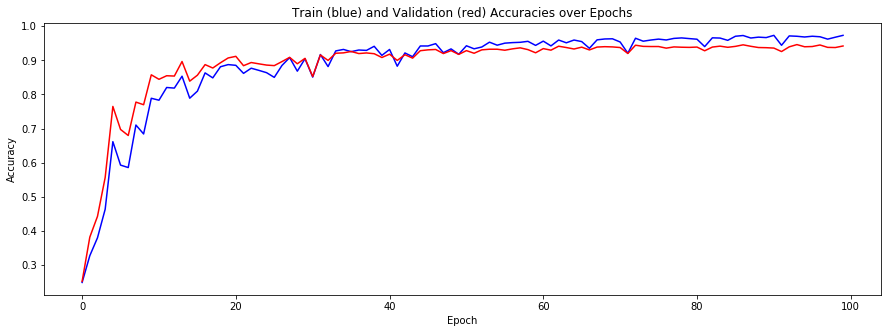

In [30]:
# Transpose accuracy_history
hist = np.transpose(np.array(accuracy_history))
plt.plot(hist[0], 'b')  # training accuracy
plt.plot(hist[1], 'r')  # validation accuracy
plt.title('Train (blue) and Validation (red) Accuracies over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()


## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

In [32]:
# Read sample image files, resize them, convert to numpy arrays w/ dtype=uint8
image_files  = ['sample_images/' + image_file for image_file in os.listdir('sample_images')]
images = []
for image_file in image_files:
    image = Image.open(image_file)
    image = image.convert('RGB')
    image = image.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
    image = np.array(list(image.getdata()), dtype='uint8')
    image = np.reshape(image, (32, 32, 3))

    images.append(image)
images = np.array(images, dtype='uint8')

### Load and Output the new Images

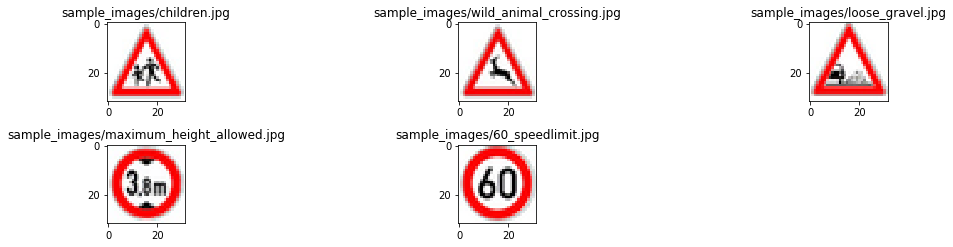

In [33]:
# Visually inspect sample images
for i, image in enumerate(images):
    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    plt.title(image_files[i])

plt.tight_layout()
plt.show()

Even though my samples images have a bright resolution and high quality images. The quality of the images used for training, validation and testing are quite poor. Image quality has a effect on convolutional neural network model accuracy. According to this paper. Higher image quality will produce better prediction accuracy results.[Understanding How Image Quality Affects Deep Neural Networks](https://arxiv.org/pdf/1604.04004.pdf).    
I could improve the predictions of the new image sample results by augmenting the validation iamge set.

### Predict the Sign Type for Each Image

In [34]:
# Load signnames.csv to map label number to sign string
label_map = {}
with open('signnames.csv', 'r') as f:
    first_line = True
    for line in f:
        # Ignore first line
        if first_line:
            first_line = False
            continue

        # Populate label_map
        label_int, label_string = line.split(',')
        label_int = int(label_int)

        label_map[label_int] = label_string

In [69]:
# Pre-process the image 
images, _ = preprocess_data(images, np.array([0 for _ in range(images.shape[0])]))

with tf.Graph().as_default(), tf.Session() as sess:
    # Instantiate the CONV NN model
    x, y, keep_prob, logits, optimizer, predictions, accuracy = conv_neural_net()

    # Load trained weights
    saver = tf.train.Saver()
    saver.restore(sess, MODEL_SAVE_PATH)
    
    # Run inference on CNN to make predictions, and remember the logits for later
    lgts, preds = sess.run([logits, predictions], feed_dict={x: images, keep_prob: 1.})

final_preds = [label_map[pred] for pred in preds]

INFO:tensorflow:Restoring parameters from model.ckpt


In [40]:
# Print predictions on my sample images
print('Predictions on sample images\n')
for i in range(images.shape[0]):
    print('%s --> %s' % (image_files[i], final_preds[i]))

Predictions on sample images

sample_images/children.jpg --> Children crossing

sample_images/wild_animal_crossing.jpg --> Wild animals crossing

sample_images/loose_gravel.jpg --> Yield

sample_images/maximum_height_allowed.jpg --> Go straight or right

sample_images/60_speedlimit.jpg --> Speed limit (60km/h)



### Predictions on sample images

Predictions on sample images

sample_images/children.jpg --> Children crossing  **This is the correct predicition**

sample_images/wild_animal_crossing.jpg --> Wild animals crossing **This is the correct predicition**

sample_images/loose_gravel.jpg --> Yield **This is not the correct predicition**

sample_images/maximum_height_allowed.jpg --> Go straight or right **This is not the correct predicition**

sample_images/60_speedlimit.jpg --> Speed limit (60km/h) **This is the correct predicition**

The accuracy rate of the prediction is 60% (3/5)

### Analyze Performance
Comparing the results to predicting on the test set

In [41]:
# Load the German Traffic Sign training set again
training_file = 'train.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']

# For each of the 5 predictions,
# find an image in the test set that matches the predicted class
train_images = []
for pred in preds:
    for i, y in enumerate(y_train):
        if y == pred:
            train_images.append(X_train[i])
            break

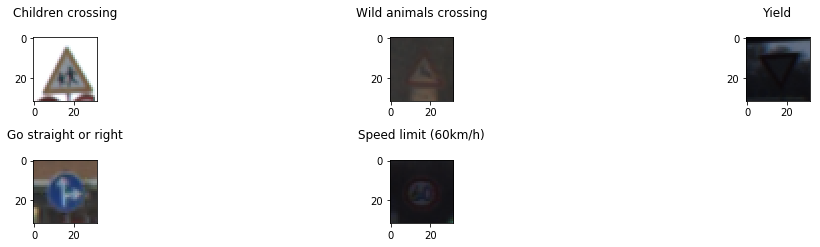

In [42]:
# Display images from test set
for i, image in enumerate(train_images):
    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    plt.title(final_preds[i])

plt.tight_layout()
plt.show()    

### Comparing the performance on the new images to the accuracy results of the test set
* sample_images/children.jpg --> Children crossing, Test Set --> Children crossing 100% match 
* sample_images/wild_animal_crossing.jpg --> Wild animals crossing, Test Set --> Wild animals crossing 100% match 
* sample_images/loose_gravel.jpg --> Yield, Test Set --> Yield no match, Test Set prediction correct but not a match on the new image
* sample_images/maximum_height_allowed.jpg --> Go straight or right, Test Set --> , Test Set prediction correct but not a match on the new image
* sample_images/60_speedlimit.jpg --> Speed limit (60km/h), Test Set --> Speed limit (60km/h)100% match

The test set has an accuracy of 100% compared to the new sample image prediction accuracy of 60%. This can be attributed to overfitting on the test set. The image quality is also a determining factor on these results.

### Output Top 5 Softmax Probabilities For Each Image

In [43]:
# Use TensorFlow's softmax and top_k functions
with tf.Graph().as_default(), tf.Session() as sess:
    logits = tf.placeholder('float', [None, NUM_CLASSES])
    softmax = tf.nn.softmax(logits)
    top_k_val, top_k_idx = tf.nn.top_k(softmax, k=5)
    
    top_k_vals, top_k_idxs = sess.run([top_k_val, top_k_idx], feed_dict={logits: lgts})

In [44]:
def display_pred_certainty(image, top_k_val, top_k_idx):
    print('Top 5 predictions for the following image (prediction: probability)')
    # Convert top k indices into strings
    top_k_pred = [label_map[idx] for idx in top_k_idx]
    
    # Show the image for reference
    plt.imshow(image)
    plt.show()
    
    for i in range(5):
        print('%s: %.2f%%' % (top_k_pred[i].replace('\n', ''), top_k_val[i] * 100))

In [45]:
# Re-read sample images
image_files  = ['sample_images/' + image_file for image_file in os.listdir('sample_images')]
images = []
for image_file in image_files:
    image = Image.open(image_file)
    image = image.convert('RGB')
    image = image.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
    image = np.array(list(image.getdata()), dtype='uint8')
    image = np.reshape(image, (32, 32, 3))

    images.append(image)
images = np.array(images, dtype='uint8')

### Display top 5 predictions for each sample image

Top 5 predictions for the following image (prediction: probability)


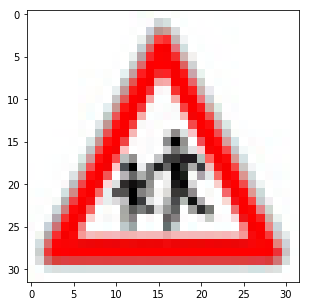

Children crossing: 100.00%
Road narrows on the right: 0.00%
Bicycles crossing: 0.00%
Road work: 0.00%
Slippery road: 0.00%


In [46]:
i = 0
display_pred_certainty(images[i], top_k_vals[i], top_k_idxs[i])

Top 5 predictions for the following image (prediction: probability)


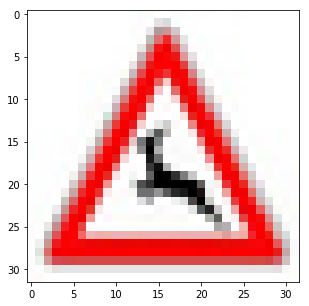

Wild animals crossing: 100.00%
Dangerous curve to the right: 0.00%
Double curve: 0.00%
Road work: 0.00%
Dangerous curve to the left: 0.00%


In [47]:
i = 1
display_pred_certainty(images[i], top_k_vals[i], top_k_idxs[i])

Top 5 predictions for the following image (prediction: probability)


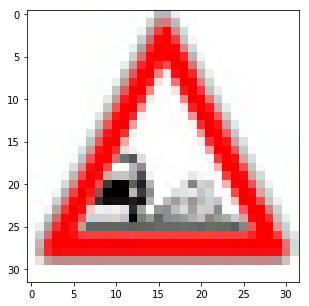

Yield: 99.98%
No vehicles: 0.01%
Bicycles crossing: 0.00%
Bumpy road: 0.00%
Beware of ice/snow: 0.00%


In [48]:
i = 2
display_pred_certainty(images[i], top_k_vals[i], top_k_idxs[i])

Top 5 predictions for the following image (prediction: probability)


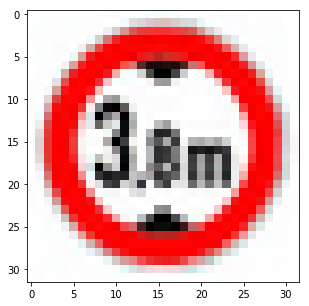

Go straight or right: 76.04%
Go straight or left: 11.88%
Ahead only: 7.29%
Right-of-way at the next intersection: 1.60%
Speed limit (30km/h): 1.35%


In [49]:
i = 3
display_pred_certainty(images[i], top_k_vals[i], top_k_idxs[i])

It looks like the No passing sign hence the confusion

Top 5 predictions for the following image (prediction: probability)


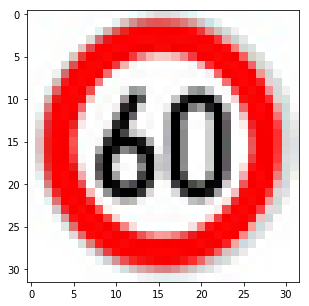

Speed limit (60km/h): 72.58%
Speed limit (50km/h): 26.28%
Speed limit (30km/h): 0.84%
Speed limit (80km/h): 0.30%
No passing: 0.00%


In [50]:
i = 4
display_pred_certainty(images[i], top_k_vals[i], top_k_idxs[i])

## German road sign examples from the web
I obtained the above 5 images from a dataset of German traffic signs [German Traffic Signs](https://www.adac.de/_mmm/pdf/fi_verkehrszeichen_engl_infobr_0915_30482.pdf)

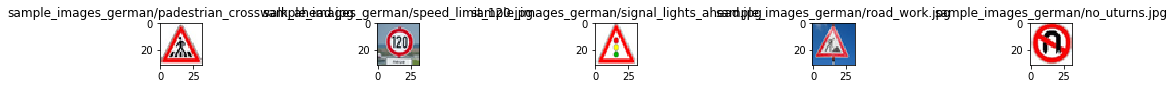

In [51]:
# Read sample image files, resize them, convert to numpy arrays w/ dtype=uint8
image_files  = ['sample_images_german/' + image_file for image_file in os.listdir('sample_images_german')]
images = []
for image_file in image_files:
    image = Image.open(image_file)
    image = image.convert('RGB')
    image = image.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
    image = np.array(list(image.getdata()), dtype='uint8')
    image = np.reshape(image, (32, 32, 3))

    images.append(image)
images = np.array(images, dtype='uint8')

# Visually inspect sample images
for i, image in enumerate(images):
    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.title(image_files[i])

plt.tight_layout()
plt.show()

In [52]:
# Load signnames.csv to map label number to sign string
label_map = {}
with open('signnames.csv', 'r') as f:
    first_line = True
    for line in f:
        # Ignore first line
        if first_line:
            first_line = False
            continue

        # Populate label_map
        label_int, label_string = line.split(',')
        label_int = int(label_int)

        label_map[label_int] = label_string
        
# Pre-process the image (don't care about label, put dummy labels)
images, _ = preprocess_data(images, np.array([0 for _ in range(images.shape[0])]))

with tf.Graph().as_default(), tf.Session() as sess:
    # Instantiate the CNN model
    x, y, keep_prob, logits, optimizer, predictions, accuracy = conv_neural_net()

    # Load trained weights
    saver = tf.train.Saver()
    saver.restore(sess, MODEL_SAVE_PATH)
    
    # Run inference on CNN to make predictions, and remember the logits for later
    lgts, preds = sess.run([logits, predictions], feed_dict={x: images, keep_prob: 1.})

final_preds = [label_map[pred] for pred in preds]

# Print predictions on my sample images
print('Predictions on sample images\n')
for i in range(images.shape[0]):
    print('%s --> %s' % (image_files[i], final_preds[i]))

INFO:tensorflow:Restoring parameters from model.ckpt
Predictions on sample images

sample_images_german/padestrian_crosswalk_ahead.jpg --> Children crossing

sample_images_german/speed_limit_120.jpg --> Speed limit (120km/h)

sample_images_german/signal_lights_ahead.jpg --> Traffic signals

sample_images_german/road_work.jpg --> Road work

sample_images_german/no_uturns.jpg --> No passing



### Predictions on German sample images

sample_images_german/padestrian_crosswalk_ahead.jpg --> Children crossing **This is the correct prediction **

sample_images_german/speed_limit_120.jpg --> Speed limit (120km/h) **This is the correct prediction **

sample_images_german/signal_lights_ahead.jpg --> Traffic signals **This is the correct prediction **

sample_images_german/road_work.jpg --> Road work **This is the correct prediction **

sample_images_german/no_uturns.jpg --> No passing **This is not the correct prediction ** There are similarities though between the No U-turns traffic sign and the No passing sign. I can understand this misclassification.

Our prediction accuracy is 80%. The model accuracy has improved by 20% which is quite significantly from the previous prediction. As earlier referenced the image quality has an effect on the model accuracy. It would be also intersting to visualize softmax because I could see what is causing some of the misclassification.

In [53]:
# Use TensorFlow's softmax and top_k functions
with tf.Graph().as_default(), tf.Session() as sess:
    logits = tf.placeholder('float', [None, NUM_CLASSES])
    softmax = tf.nn.softmax(logits)
    top_k_val, top_k_idx = tf.nn.top_k(softmax, k=5)
    
    top_k_vals, top_k_idxs = sess.run([top_k_val, top_k_idx], feed_dict={logits: lgts})
    
    
# Re-read sample image files, resize them, convert to numpy arrays w/ dtype=uint8
image_files  = ['sample_images_german/' + image_file for image_file in os.listdir('sample_images_german')]
images = []
for image_file in image_files:
    image = Image.open(image_file)
    image = image.convert('RGB')
    image = image.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
    image = np.array(list(image.getdata()), dtype='uint8')
    image = np.reshape(image, (32, 32, 3))

    images.append(image)
images = np.array(images, dtype='uint8')

def pred_certainty_str(top_k_val, top_k_idx):
    # Convert top k indices into strings
    top_k_pred = [label_map[idx] for idx in top_k_idx]
    
    pcs = ''
    for i in range(5):
        pcs += '%s: %.2f%%\n' % (top_k_pred[i].replace('\n', ''), top_k_val[i] * 100)
        
    return pcs

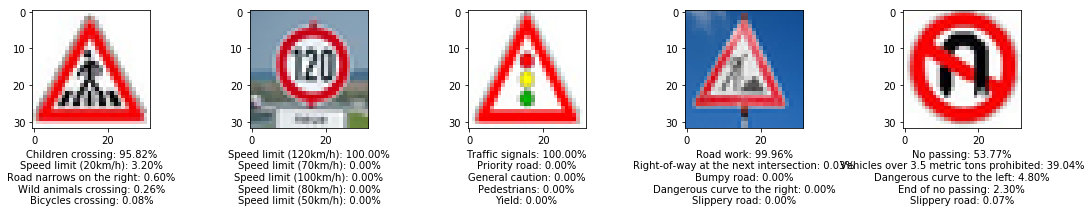

In [54]:
for i, image in enumerate(images):
    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.xlabel(pred_certainty_str(top_k_vals[i], top_k_idxs[i]))

plt.tight_layout()
plt.show()


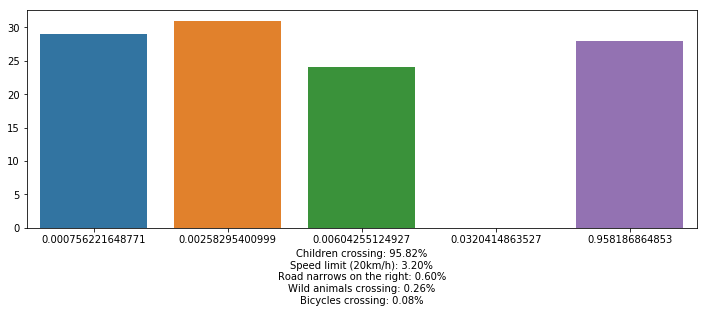

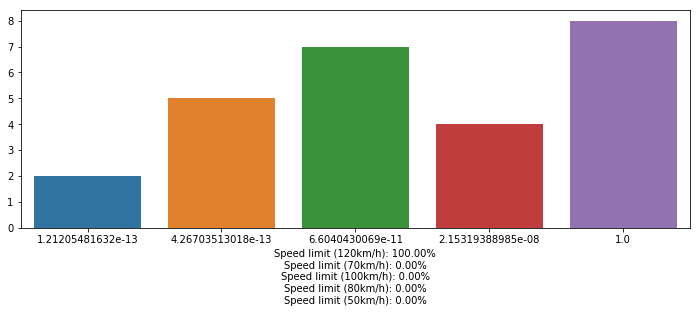

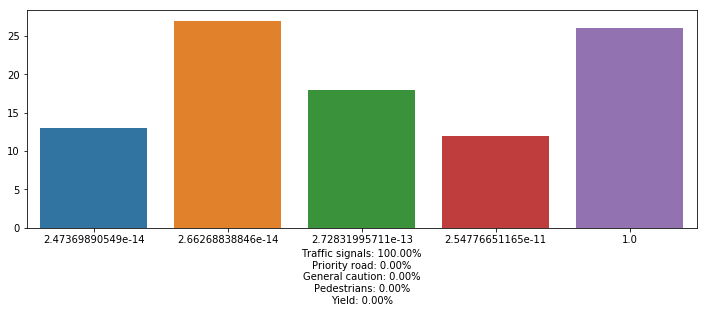

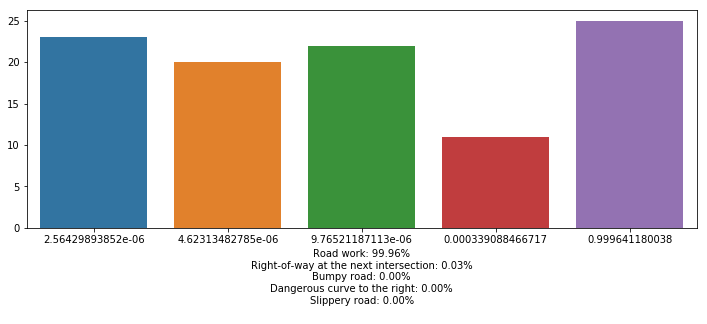

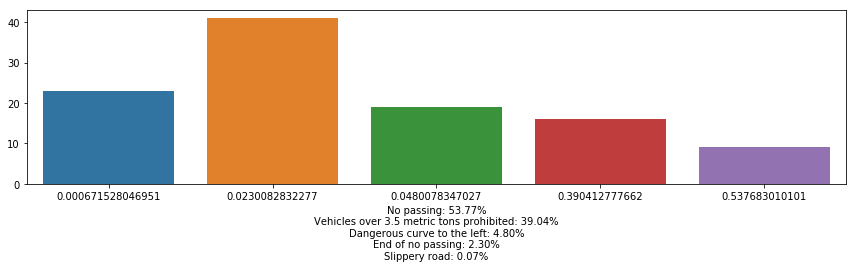

In [63]:
import seaborn as sns
for i, image in enumerate(images):
    fig = plt.figure(figsize=(12,4))
    plt.xlabel(pred_certainty_str(top_k_vals[i], top_k_idxs[i]))
    sns.barplot(x = top_k_vals[i], y = top_k_idxs[i])   
plt.tight_layout()
plt.show()

The prediction probabilities are good. I can understand why the model is getting confused about the No U-Turn sign does look quite similar to the No-Passing sign and also it appears that the No U-Turn was not included in this training set hence also the misclassification.